# SIADS 521 Visual Exploration of Data
#### Adam Bakopolus - Assignment 4

This final assignment for the course will take a lot of what was learned during the previous 3 weeks (probability density functions, box and violin blots, SPLOMS, geographical plotting, etc.) and apply these functions and skills to datasets revolving around strava exercise data. The goal of this project is to visually present this exercise and geographical data in a meaningful way to allow for insights to be drawn by the reader and audience. To start, the usual libraries like numpy, pandas, scipy stats, and matplot lib are pulled in for this work. 

Additionally, as will be seen throughout the notebook, the fitparse library is needed to read in some additional strava data, datetime is used to further manipulate the timestamp data within the strava file, and seaborn and folium are pulled in as the preferred libraries to do the plotting heavy lifting. Lastly, as a way to see all the columns within a pandas DataFrame easily, the pd.set_option for max columns is set to 500, to avoid cases where a .head() function will have a "..." between columns. With this being an unknown data set, the preference was to have the full DataFrame available for review despite its large width.

<b> Rule 3: Use Cell Divisions to Make Steps Clearer </b>

For this assignment, the rules I will discuss all for the most part assist with Rule 1, which is to tell a story for the audience. This story is made clearer through the use of cell divisions - each cell for this project will have a goal that it accomplishes and, to not overwhelm the reader, cells are broken out frequently to allow for as much clarity as possible. For example, the cells below detail the libraries and modules that are needed for this project and each cell division is explained either before or after with annotations or markdown cells (which is noted in Rule 2 below).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from fitparse import FitFile
from datetime import datetime
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
pd.set_option('display.max_columns', 500)

## Data Intake and Preparation

As noted above, there was additional information around the 64 workouts done by Professor Brooks in the summer and fall of 2019, and these .fit files were available in the "bonus" folder in the Jupyter lab repository. Utilizing the FitFile function would allow for detail around the session or workout to be parsed. In particular, this would be most helpful in determining whether the workout was a running or cycling activity, which would be found in different columns depending on the activity. This process, unfortunately, would manually need to be done for the 64 workouts but the data could then be utilized moving forward. An example is seen below for this process. Source/data generated from this process was made available in the Slack channel as well as part of the project discussion.

<b>Rule #2 Document the Process, Not Just the Results</b>

As opposed to just simply showing code and leaving it up to the reader to understand or digest independently, the way this notebook is laid out will hopefully allow for the reader and audience to easily follow along. Prior to each cell there will be discussion around why a certain step was taken and the general thought process around building the overall notebook. Additionally, in cells with more involved coding/steps, the logic is annotated to allow even those without familiarity with the procedures/libraries to walk through and understand the rationale.

<b>Rule #9 Design Notebooks to be Read, Run, and Explored</b>

As will be seen throughout this notebook, the goal is not only to generate meaningful insights for the reader and audience but to present the data, results, etc. in a way that is easily digestible. This notebook is designed to be easily read through extensive use of annotations and markdown cells to step by step explain the process. The notebook is designed in a way that, with the appropriate access to the fit-related files, the kernel can be reset and all cells can be run without error. Additionally, the notebook is very easy to explore and has clear markdowns and annotations that also lead to visual representations of the data, as well.

In [2]:
fit = FitFile('/home/jovyan/work/resources/bonus/2688518063.fit')
fit_session = fit.get_messages('session')
session_df = pd.DataFrame(fit_session)
session_df[[51, 53]]

,51,53
0,sport: running,start_position_lat: 504427594 [semicircles]


The strava file, where the data most predominantly used for this analysis presides, was then also read in as a DataFrame for use and the columns comprising this file can also be seen below. In particular, fields like cadence, datafile, distance, enhanced_speed, heart rate, position lat and long, timestamp, etc. would be the major focus of this project.

In [3]:
strava = pd.read_csv('strava.csv')
strava.columns

Index(['Air Power', 'Cadence', 'Form Power', 'Ground Time',
       'Leg Spring Stiffness', 'Power', 'Vertical Oscillation', 'altitude',
       'cadence', 'datafile', 'distance', 'enhanced_altitude',
       'enhanced_speed', 'fractional_cadence', 'heart_rate', 'position_lat',
       'position_long', 'speed', 'timestamp', 'unknown_87', 'unknown_88',
       'unknown_90'],
      dtype='object')

The activity_type .csv file below is the 64 datafiles/workouts from Professor Brooks and whether or not the activity was running or cycling, which again could be determined through the use of the FitFile function above. These determinations for the datafiles were merged into the larger strava dataset with the logic below by joining on the datafile itself.

In [4]:
activity_type = pd.read_csv('activity_type.csv')
strava = pd.merge(strava, activity_type, how = 'inner', left_on = 'datafile', right_on = 'datafile')

In addition to running/cycling, another breakout I was interested in was how the workouts may have differed based on the time of year, whether there were longer workouts in the summer vs. fall, etc. The approach to incorporate a "season" column in the pandas DataFrame is below with the code annotated for an explanation.

In [5]:
#Convert the timestamp field into a datetime (datetime library AND module needed to be imported earlier)
strava['timestamp'] = pd.to_datetime(strava['timestamp'])
#The strftime will create a string from this datetime with the specified YYYY-MM-DD structure
strava['timestamp'] = strava['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))
#With hours, minutes, and seconds removed, the timestamp field is again set to a datetime
strava['timestamp'] = pd.to_datetime(strava['timestamp'])

#Function that assigns a season based on the time of the activity
def seasons(val):
    seasons_dict = {'spring': pd.date_range(start='20/03/2019', end='20/06/2019'),
                    'summer': pd.date_range(start='21/06/2019', end='22/09/2019'),
                    'fall': pd.date_range(start='23/09/2019', end='20/12/2019')}
    if val in seasons_dict['spring']:
        return 'Spring'
    if val in seasons_dict['summer']:
        return 'Summer'
    if val in seasons_dict['fall']:
        return 'Fall'
    else:
        return 'Winter'
#Above function is used to map the timestamp column in the DataFrame and create the Season column
strava['Season'] = strava.timestamp.map(seasons)
#MPH and Miles columns are created by converting m/s to mph and meters to miles, respectively
strava['MPH'] = strava['enhanced_speed'] * 2.23694
strava['Miles'] = strava['distance'] * 0.000621371

With these new fields in the strava dataset, a groupby statement is then run to create a new strava_agg table that has data at a workout, run/bike ride, and season level for values like total miles, average altitude, average heart rate, etc. as can be seen below following the .head() function

In [6]:
strava_agg = strava.groupby(['datafile', 'activity', 'Season'], as_index = False).agg({'Miles': ['max'],
                                                                     'altitude': ['mean'],
                                                                     'heart_rate': ['mean'],
                                                                     'Power': ['mean'],
                                                                     'cadence': ['mean'],
                                                                     'MPH': ['mean']})

strava_cols = ['datafile', 'activity', 'season', 'miles_total', 'avg_altitude', 'avg_heart_rate', 'avg_power', 'avg_cadence', 'avg_mph']
strava_agg.columns = strava_cols
strava_agg.head()

,datafile,activity,season,miles_total,avg_altitude,avg_heart_rate,avg_power,avg_cadence,avg_mph
0,activities/2675855419.fit.gz,running,Summer,1.626414,3823.037037,118.337398,NaN,74.406504,4.671076
1,activities/2677658978.fit.gz,running,Summer,0.528128,3769.823529,122.117647,NaN,77.191176,5.858316
2,activities/2677658993.fit.gz,running,Summer,0.526637,3794.425926,135.592593,NaN,81.777778,6.003450
3,activities/2677659014.fit.gz,running,Summer,0.518752,3767.767857,134.571429,NaN,79.517857,5.452941
4,activities/2682705331.fit.gz,running,Summer,4.643916,3854.755214,117.687157,NaN,74.135016,4.398298


## Visualization of the Data

#### Scatterplot Matrices (SPLOMs)

With this new data set created, we'll look at two scatterplot matrices, or SPLOMS, for total miles, average altitude, average heart rate, average power, average cadence, and average MPH at 1.) An activity (running/cycling) level for the first SPLOM and at 2.) a seasonal (summer and fall) level for the second SPLOM. Seaborn is an extremely powerful library for generating SPLOMs and is the chosen approach for these first two plots. As seen below, the pairplot function can be utilized to generate these scatterplot matrices with the legend specified by the "hue" parameter.

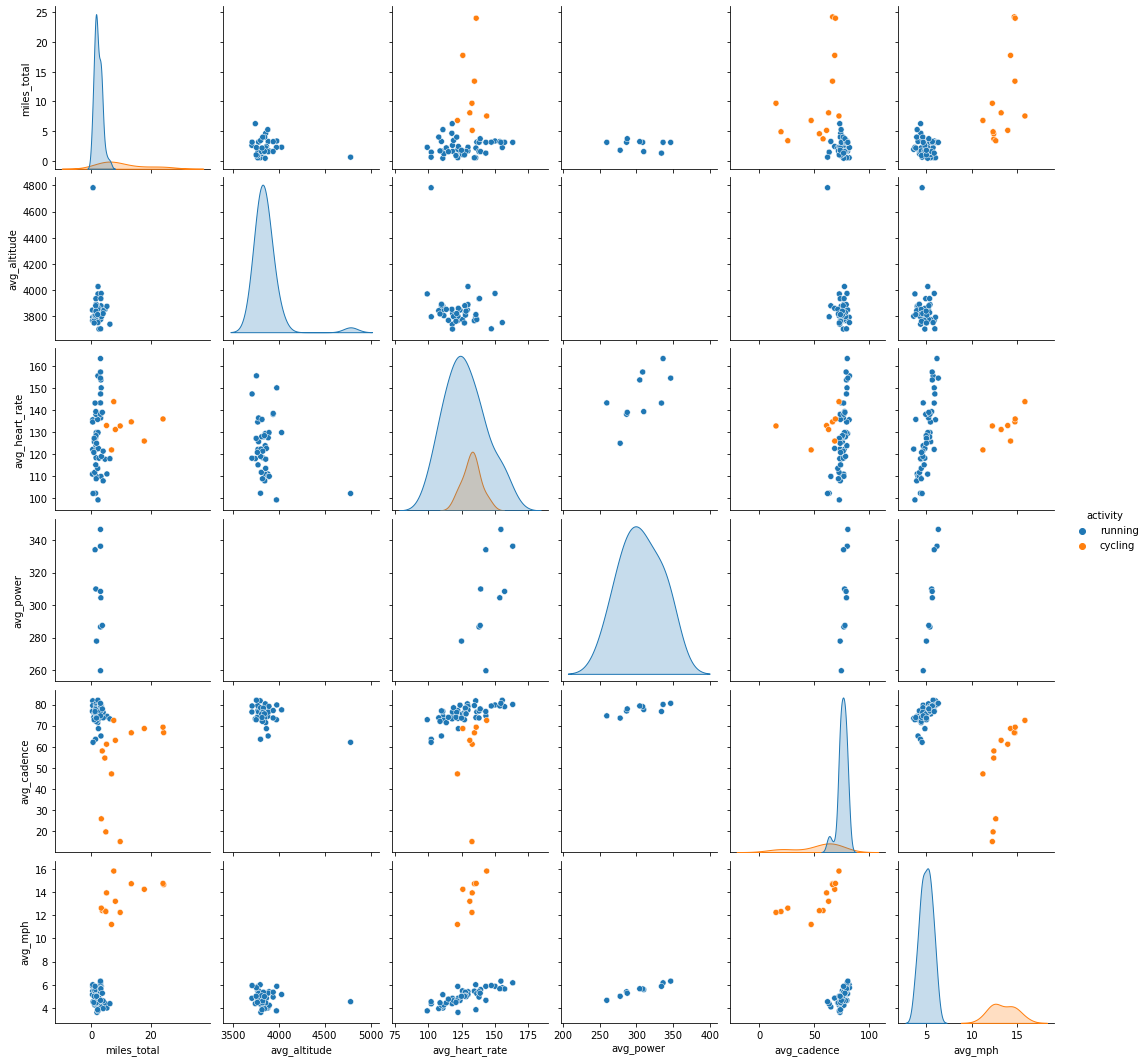

In [7]:
strava_sb_act = strava_agg[['activity', 'miles_total', 'avg_altitude', 'avg_heart_rate', 'avg_power', 'avg_cadence', 'avg_mph']]
sns.pairplot(strava_sb_act, hue = 'activity') #SPLOM Comparing Cycling and Running
plt.show()

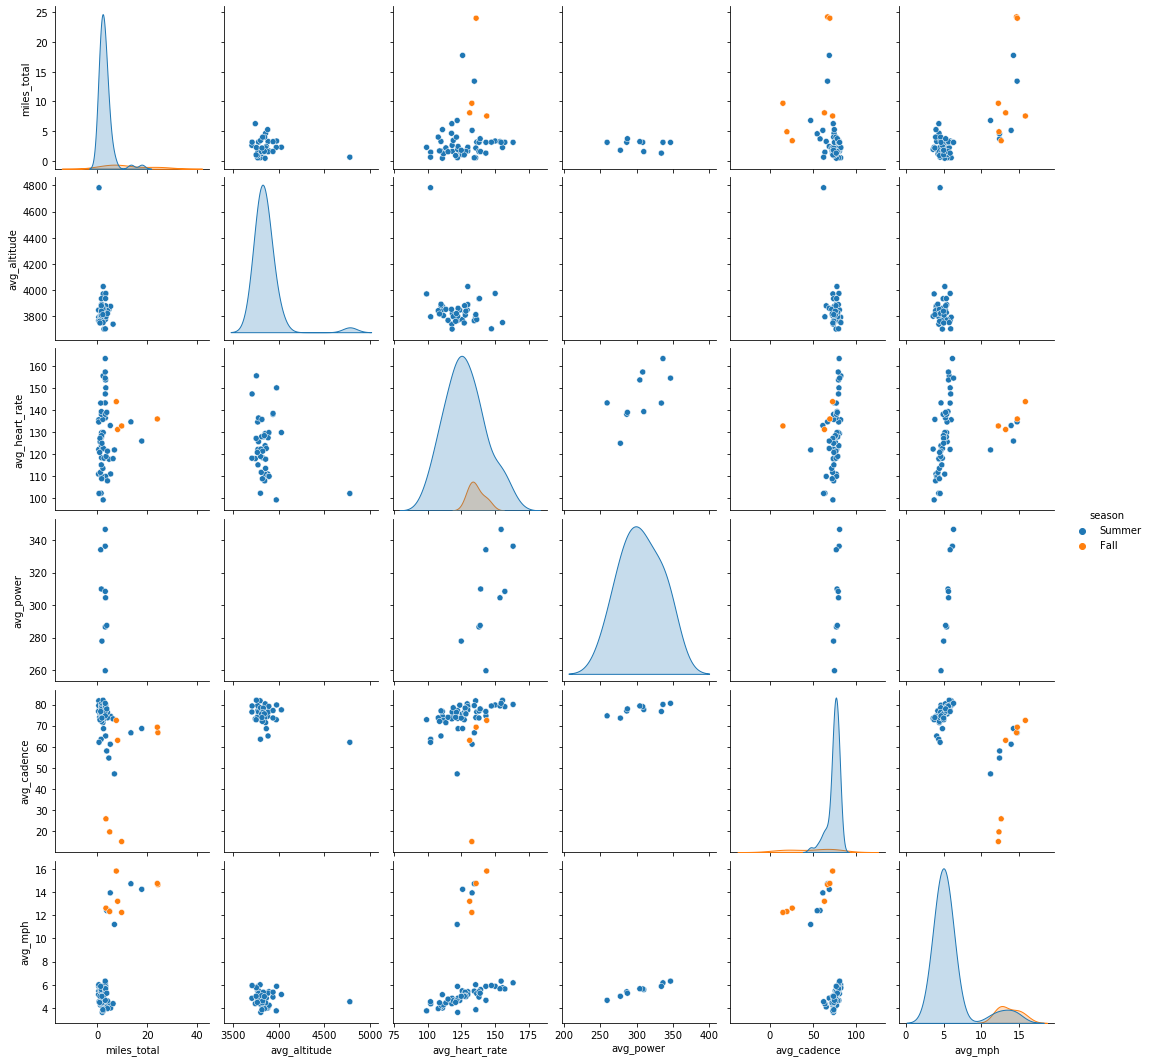

In [8]:
strava_sb_sea = strava_agg[['season', 'miles_total', 'avg_altitude', 'avg_heart_rate', 'avg_power', 'avg_cadence', 'avg_mph']]
sns.pairplot(strava_sb_sea, hue = 'season') #SPLOM comparing Summer and Fall
plt.show()

SPLOMs are a great way to gain meaningful insights very quickly and through a very easy to digest display that can easily be interpreted by the reader. The goal of these two SPLOMs were to see if any notable/worthwhile conclusions can be drawn when comparing certain average variables to each other across Cycling vs. Running and Summer vs. Fall. Unfortunately, with Fall only comprising a small sub-section of the data, meaningful insights could not be easily determined. However, I believe there was much value when comparing cycling to running, which was done with the first SPLOM. Running workouts looked to be much more consistent in terms of cadence for Professor Brooks and there looked to be more variability when cycling. These seems reasonable given that cycling workouts will tend to be longer and, as such, are more susceptible to terrain differences. Difficult uphill or easy downhill days would be reflected in less compact cadence data, as opposed to running workouts which are again shorter and likely around the same area each time.

#### Probability Density Function and Histogram

For the next visualization, average heart rate across both running and cycling and all seasons was investigated. The code below is annotated to assist in detailing the process.

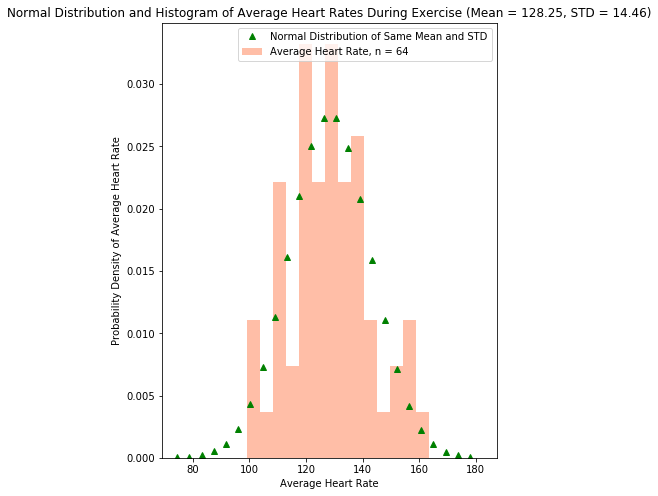

In [9]:
#Find the Average Heart Rate of the 64 workouts and the standard deviation
mean_hr = np.mean(strava_agg['avg_heart_rate'])
std_hr = np.std(strava_agg['avg_heart_rate'])

#Based on the above mean and standard deviations, generate a normal sample with the same mean and STD
normal_sample = np.random.normal(mean_hr, std_hr, 500)
normal_dist = stats.norm(loc = mean_hr, scale = std_hr)

#Generate appropriate x-values for the normal distribution based on percent point functions
#And appropriate y-values based on a probability density function of the prior generated x-values
norm_x = np.linspace(normal_dist.ppf(0.0001), normal_dist.ppf(0.9999), 500)
norm_y = normal_dist.pdf(norm_x)

#Generate a figure that has the above normal distribution overlayed onto a histogram of average heart rate of the
#64 workouts, with appropriate labels. The histogram is normed, meaning that the area under the histogram will be 1
fig = plt.figure(figsize=(6, 8))

heart_rate = fig.add_subplot(111)
heart_rate.plot(norm_x, norm_y, 'g^', label = 'Normal Distribution of Same Mean and STD', markevery = 20)
heart_rate.hist(strava_agg['avg_heart_rate'], normed = True, bins = 14, alpha = 0.5, color = 'coral',
             label = 'Average Heart Rate, n = 64')
heart_rate.title.set_text('Normal Distribution and Histogram of Average Heart Rates During Exercise (Mean = 128.25, STD = 14.46)')
heart_rate.set(xlabel='Average Heart Rate', ylabel='Probability Density of Average Heart Rate')
heart_rate.legend()
plt.show()

A normal distribution overlayed onto the probability density function is a very valuable and quick way to decipher whether the data can be considered normal. While the average heart rate data looks fairly normal, there are cases around the tails that have far more occurences than expected, leading to the conclusion that this data, while close, can not be considered normal. However, the ability to overlay multiple plots onto a subplot is extremely valuable in not just visualizing the data itself, but also evaluating it.

#### Violin and Box Plots

Lastly, for the "basic" plots, Seaborn will again be used for the below box and violin plots due to its simplicity. The logic for violin plots and then box plots is presented below.

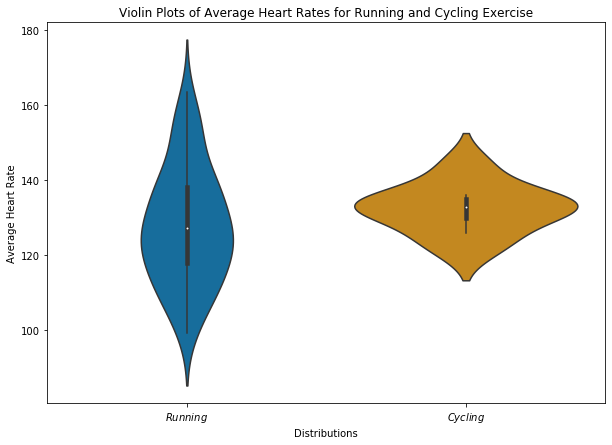

In [10]:
#Use a mask to limit the DataFrame to running-only or cycling-only
strava_run_agg = strava_agg[strava_agg['activity'] == 'running']['avg_heart_rate']
strava_cycle_agg = strava_agg[strava_agg['activity'] == 'cycling']['avg_heart_rate']

distributions = [np.array(strava_run_agg), np.array(strava_cycle_agg)]
plt.figure(figsize = (10, 7))
sns.violinplot(data = distributions, 
    palette = 'colorblind').set_title('Violin Plots of Average Heart Rates for Running and Cycling Exercise')
plt.xlabel('Distributions')
plt.ylabel('Average Heart Rate')
plt.xticks([0, 1], ['$Running$', '$Cycling$'])
plt.show()

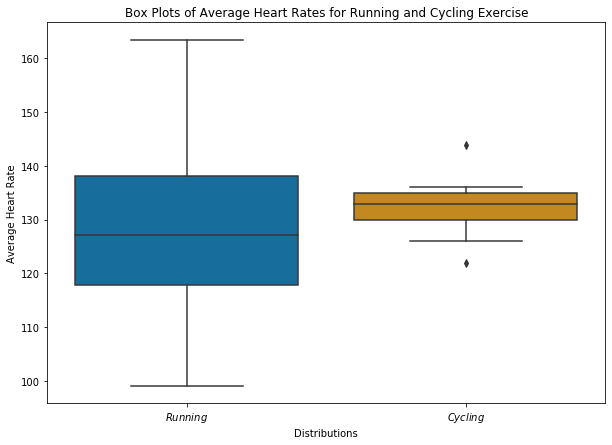

In [11]:
plt.figure(figsize = (10, 7))
sns.boxplot(data = distributions, 
    palette = 'colorblind').set_title('Box Plots of Average Heart Rates for Running and Cycling Exercise')
plt.xlabel('Distributions')
plt.ylabel('Average Heart Rate')
plt.xticks([0, 1], ['$Running$', '$Cycling$'])
plt.show()

Both the violin and box plots are comparing Running workouts to Cycling Workouts. From these two plots, it is very clear to see that cycling workouts lead to Professor Brooks having a higher average heart rate. From the violin plot specifically, it is clear that the cycling data, due to a low n, has a very steep distribution and is affected more strongly but each workout due to the limited data available. Running data's distributioon looks relatively normal (though likely not exactly due to what was seen earlier with the PDF plot). The box plot shows that the running data has a larger interquartile range relative to the cycling data and the cycling data even has workouts that are categorized as outliers. 

### Advanced Technique - Folium Heat Map

Lastly for this data investigation, folium will be used to generate a heat map to track where Professor Brooks often goes for his running and cycling workouts.

In [12]:
strava['lat'] = strava['position_lat'] * (180 / 2**31)
strava['long'] = strava['position_long'] * (180 / 2**31)

strava['lat'] = strava['lat'].astype(float)
strava['long'] = strava['long'].astype(float)

m = folium.Map(location=[42.3, -83.8], #This is arbitrary but was an educated guess based on the lat and 
                                       #long positions calculated above
                    zoom_start = 11) 

heat_strava = strava[['lat', 'long']]
heat_strava = heat_strava.dropna(axis=0)
heat_vals = heat_strava.values.tolist()

HeatMap(heat_vals).add_to(m)

m

While there is a very clear region that houses much of the workout time from Professor Brooks, there is also a tail that has a notable amount of workout time, as well. This heatmap is therefore very helpful in establishing the predominant regions where Professor Brooks not only goes for runs but also for cycling workouts (the tail region - as this is a "further" away spot from the typical start location).

All in all this heat map was very valuable in geographically evaluating the strava data and allowed for us to make clear the general locations of the 64 workouts Professor Brooks went on during the Summer and Fall of 2019. More specifically, the heat map also made clear that regions further away from the "starting" point would be generated from the cycling workouts, that typically covered a much greater distance when compared to the runs.

Earlier in the workbook, SPLOMs, Probability Density Functions, Violin and Box Plots all played a role in generating meaningful insights from the strava data. The SPLOMs generated clear relational scatter plots across multiple aggregated data fields, the PDF compared average heart rate data to a normal distribution (allowing for the determination that the data was not normal to be made), and violin and box plots further investigated average heart rate across the running and cycling data to draw a notable comparison that average heart rate was greater during cycling workouts (although the data size itself was limited for this exercise type). With annotated code and descriptions along the way that walked through new techniques (FitFile, folium, for example) the hope is that this notebook provided an effective tutorial for displaying fitness data in a clear and meaningful way.